<a href="https://colab.research.google.com/github/kvijay0611/ResNet-vs-Plain-CNN-on-CIFAR-10/blob/main/Computervisionintern.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### ResNet vs PlainNet on CIFAR-10
 implement ResNet (with residual/skip connections) and PlainNet (same-depth, no skip)
Train both on CIFAR-10, log metrics, plot training curves, and run small extensions.

In [ ]:
!pip install -q torch torchvision matplotlib scikit-learn tqdm

In [ ]:
import os
import time
import copy
import random
from pathlib import Path

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as transforms

In [ ]:
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, accuracy_score

In [ ]:
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [ ]:
seed_everything(42)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cuda


In [ ]:
CONFIG = {
'batch_size': 128,
'epochs': 69,
'lr': 0.1,
'momentum': 0.9,
'weight_decay': 5e-4,
'seed': 42,
'num_workers': 2,
'save_dir': './results',
}

In [ ]:
os.makedirs(CONFIG['save_dir'], exist_ok=True)

In [ ]:
mean = (0.4914, 0.4822, 0.4465)
std = (0.2470, 0.2435, 0.2616)


transform_train = transforms.Compose([
transforms.RandomCrop(32, padding=4),
transforms.RandomHorizontalFlip(),
transforms.ToTensor(),
transforms.Normalize(mean, std),
])
transform_test = transforms.Compose([
transforms.ToTensor(),
transforms.Normalize(mean, std),
])

In [ ]:
root = './data'
trainset = torchvision.datasets.CIFAR10(root=root, train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root=root, train=False, download=True, transform=transform_test)

100%|██████████| 170M/170M [00:07<00:00, 24.3MB/s]


In [ ]:
val_frac = 0.1
n_train = len(trainset)
n_val = int(val_frac * n_train)
train_ds, val_ds = random_split(trainset, [n_train - n_val, n_val])


train_loader = DataLoader(train_ds, batch_size=CONFIG['batch_size'], shuffle=True, num_workers=CONFIG['num_workers'])
val_loader = DataLoader(val_ds, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=CONFIG['num_workers'])
test_loader = DataLoader(testset, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=CONFIG['num_workers'])


print('Train size:', len(train_ds), 'Val size:', len(val_ds), 'Test size:', len(testset))

Train size: 45000 Val size: 5000 Test size: 10000


# Models: ResNet-style BasicBlock + ResNet for CIFAR and PlainBlock/PlainNet variant

In [ ]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, downsample=None, use_skip=True):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(in_planes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride
        self.use_skip = use_skip

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        if self.use_skip:
            out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=10, use_skip=True):
        self.in_planes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.use_skip = use_skip

        self.layer1 = self._make_layer(block, 64, layers[0], use_skip=use_skip)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, use_skip=use_skip)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, use_skip=use_skip)
        self.avgpool = nn.AvgPool2d(8)
        self.fc = nn.Linear(256 * block.expansion, num_classes)


        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1, use_skip=True):
        downsample = None
        if stride != 1 or self.in_planes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_planes, planes * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.in_planes, planes, stride, downsample, use_skip=use_skip))
        self.in_planes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_planes, planes, use_skip=use_skip))

        return nn.Sequential(*layers)

    def forward(self, x, return_features=False):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        feats = torch.flatten(x, 1)
        out = self.fc(feats)
        if return_features:
            return out, feats
        return out

In [ ]:
def resnet20(num_classes=10):
    return ResNet(BasicBlock, [3, 3, 3], num_classes=num_classes, use_skip=True)


def plain20(num_classes=10):
    # same architecture but without skip connections
    return ResNet(BasicBlock, [3, 3, 3], num_classes=num_classes, use_skip=False)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


# Quick smoke-test: instantiate and print params
model_res = resnet20().to(device)
model_plain = plain20().to(device)
print('ResNet params:', count_parameters(model_res))
print('PlainNet params:', count_parameters(model_plain))

ResNet params: 4327754
PlainNet params: 4327754


# Training & evaluation helpers

In [ ]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    # Iterate over the data in batches
    for inputs, targets in tqdm(dataloader, desc='Train', leave=False):

        inputs = inputs.to(device)
        targets = targets.to(device)

        # Forward pass: compute the model output
        outputs = model(inputs)

        loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss and calculate accuracy
        running_loss += loss.item() * inputs.size(0)
        _, preds = outputs.max(1)
        correct += preds.eq(targets).sum().item()
        total += targets.size(0)

    # Calculate average loss and accuracy for the epoch
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():

        for inputs, targets in tqdm(dataloader, desc='Val/Test', leave=False):

            inputs = inputs.to(device)
            targets = targets.to(device)

            # Forward pass: compute the model output
            outputs = model(inputs)
            # Compute the loss
            loss = criterion(outputs, targets)

            # Accumulate loss and calculate accuracy
            running_loss += loss.item() * inputs.size(0)
            _, preds = outputs.max(1)
            correct += preds.eq(targets).sum().item()
            total += targets.size(0)

    # Calculate average loss and accuracy for the dataset
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

In [ ]:
def plot_history(histories, labels, out_path=None):
    # histories: list of history dicts
    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    for h, lab in zip(histories, labels):
        plt.plot(h['train_acc'], linestyle='--', label=f'{lab} train')
        plt.plot(h['val_acc'], linestyle='-', label=f'{lab} val')
    plt.title('Accuracy (train dashed, val solid)')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    for h, lab in zip(histories, labels):
        plt.plot(h['train_loss'], linestyle='--', label=f'{lab} train')
        plt.plot(h['val_loss'], linestyle='-', label=f'{lab} val')
    plt.title('Loss (train dashed, val solid)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()


    plt.tight_layout()
    if out_path:
        plt.savefig(out_path, dpi=150)
    plt.show()

# Feature extraction & t-SNE helper

In [ ]:
def extract_features(model, dataloader, device, max_samples=2000):
    model.eval()
    feats = []
    labels = []
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            outputs, f = model(inputs, return_features=True)
            feats.append(f.cpu().numpy())
            labels.append(targets.numpy())
            if sum(len(x) for x in feats) >= max_samples:
                break
    feats = np.concatenate(feats, axis=0)[:max_samples]
    labels = np.concatenate(labels, axis=0)[:max_samples]
    return feats, labels

# Confusion matrix & test evaluation

In [ ]:
def evaluate_test_and_confusion(model, test_loader, device, class_names=None):
    model.eval()
    preds = []
    trues = []
    with torch.no_grad():
        for inputs, targets in tqdm(test_loader, desc='Test', leave=False):
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, p = outputs.max(1)
            preds.append(p.cpu().numpy())
            trues.append(targets.numpy())
    preds = np.concatenate(preds)
    trues = np.concatenate(trues)
    acc = (preds == trues).mean()
    cm = confusion_matrix(trues, preds)
    return acc, cm

Quick Run to verify

=== Quick test: ResNet20 ===
Epoch 1/100


Train Loss: 1.9719, Train Acc: 0.2935
Val Loss: 1.6212, Val Acc: 0.4068
Epoch 2/100


Train Loss: 1.4146, Train Acc: 0.4783
Val Loss: 1.3488, Val Acc: 0.5162
Epoch 3/100


Train Loss: 1.1015, Train Acc: 0.6048
Val Loss: 1.0575, Val Acc: 0.6194
Epoch 4/100


Train Loss: 0.8672, Train Acc: 0.6959
Val Loss: 1.1545, Val Acc: 0.6234
Epoch 5/100


Train Loss: 0.7157, Train Acc: 0.7525
Val Loss: 0.8082, Val Acc: 0.7182
Epoch 6/100


Train Loss: 0.6296, Train Acc: 0.7832
Val Loss: 0.6645, Val Acc: 0.7688
Epoch 7/100


Train Loss: 0.5683, Train Acc: 0.8025
Val Loss: 0.7257, Val Acc: 0.7466
Epoch 8/100


Train Loss: 0.5340, Train Acc: 0.8141
Val Loss: 0.6002, Val Acc: 0.7922
Epoch 9/100


Train Loss: 0.4997, Train Acc: 0.8267
Val Loss: 0.5871, Val Acc: 0.8000
Epoch 10/100


Train Loss: 0.4764, Train Acc: 0.8367
Val Loss: 0.6235, Val Acc: 0.7872
Epoch 11/100


Train Loss: 0.4597, Train Acc: 0.8427
Val Loss: 0.7597, Val Acc: 0.7354
Epoch 12/100


Train Loss: 0.4490, Train Acc: 0.8454
Val Loss: 0.5262, Val Acc: 0.8210
Epoch 13/100


Train Loss: 0.4291, Train Acc: 0.8521
Val Loss: 0.8003, Val Acc: 0.7452
Epoch 14/100


Train Loss: 0.4248, Train Acc: 0.8547
Val Loss: 0.6680, Val Acc: 0.7824
Epoch 15/100


Train Loss: 0.4059, Train Acc: 0.8628
Val Loss: 0.5385, Val Acc: 0.8234
Epoch 16/100


Train Loss: 0.3996, Train Acc: 0.8658
Val Loss: 0.7171, Val Acc: 0.7654
Epoch 17/100


Train Loss: 0.3924, Train Acc: 0.8652
Val Loss: 0.6383, Val Acc: 0.7932
Epoch 18/100


Train Loss: 0.3794, Train Acc: 0.8701
Val Loss: 0.5698, Val Acc: 0.8116
Epoch 19/100


Train Loss: 0.3747, Train Acc: 0.8702
Val Loss: 0.6303, Val Acc: 0.7900
Epoch 20/100


Train Loss: 0.3729, Train Acc: 0.8732
Val Loss: 0.4551, Val Acc: 0.8468
Epoch 21/100


Train Loss: 0.3672, Train Acc: 0.8759
Val Loss: 0.5028, Val Acc: 0.8304
Epoch 22/100


Train Loss: 0.3602, Train Acc: 0.8754
Val Loss: 0.5634, Val Acc: 0.8150
Epoch 23/100


Train Loss: 0.3579, Train Acc: 0.8778
Val Loss: 0.6782, Val Acc: 0.7814
Epoch 24/100


Train Loss: 0.3584, Train Acc: 0.8782
Val Loss: 0.5095, Val Acc: 0.8220
Epoch 25/100


Train Loss: 0.3533, Train Acc: 0.8801
Val Loss: 0.4732, Val Acc: 0.8402
Epoch 26/100


Train Loss: 0.3436, Train Acc: 0.8824
Val Loss: 0.5200, Val Acc: 0.8160
Epoch 27/100


Train Loss: 0.3399, Train Acc: 0.8829
Val Loss: 0.5529, Val Acc: 0.8206
Epoch 28/100


Train Loss: 0.3397, Train Acc: 0.8838
Val Loss: 0.5827, Val Acc: 0.8032
Epoch 29/100


Train Loss: 0.3394, Train Acc: 0.8839
Val Loss: 0.5160, Val Acc: 0.8242
Epoch 30/100


Train Loss: 0.3301, Train Acc: 0.8870
Val Loss: 0.5139, Val Acc: 0.8242
Early stopping after 10 epochs with no improvement in validation loss.
=== Quick test: PlainNet20 ===
Epoch 1/100


Train Loss: 1.7128, Train Acc: 0.3561
Val Loss: 1.6123, Val Acc: 0.4044
Epoch 2/100


Train Loss: 1.2382, Train Acc: 0.5511
Val Loss: 1.3600, Val Acc: 0.5396
Epoch 3/100


Train Loss: 0.9777, Train Acc: 0.6546
Val Loss: 1.1221, Val Acc: 0.6046
Epoch 4/100


Train Loss: 0.8219, Train Acc: 0.7144
Val Loss: 1.3756, Val Acc: 0.5742
Epoch 5/100


Train Loss: 0.7258, Train Acc: 0.7497
Val Loss: 0.9815, Val Acc: 0.6548
Epoch 6/100


Train Loss: 0.6696, Train Acc: 0.7709
Val Loss: 1.4967, Val Acc: 0.5714
Epoch 7/100


Train Loss: 0.6323, Train Acc: 0.7840
Val Loss: 0.7884, Val Acc: 0.7328
Epoch 8/100


Train Loss: 0.6052, Train Acc: 0.7932
Val Loss: 0.7607, Val Acc: 0.7404
Epoch 9/100


Train Loss: 0.5933, Train Acc: 0.7972
Val Loss: 0.8939, Val Acc: 0.6878
Epoch 10/100


Train Loss: 0.5633, Train Acc: 0.8074
Val Loss: 0.7841, Val Acc: 0.7426
Epoch 11/100


Train Loss: 0.5549, Train Acc: 0.8110
Val Loss: 0.7502, Val Acc: 0.7476
Epoch 12/100


Train Loss: 0.5439, Train Acc: 0.8129
Val Loss: 0.8423, Val Acc: 0.7144
Epoch 13/100


Train Loss: 0.5251, Train Acc: 0.8198
Val Loss: 0.7630, Val Acc: 0.7490
Epoch 14/100


Train Loss: 0.5211, Train Acc: 0.8238
Val Loss: 0.7778, Val Acc: 0.7294
Epoch 15/100


Train Loss: 0.5147, Train Acc: 0.8252
Val Loss: 0.6628, Val Acc: 0.7760
Epoch 16/100


Train Loss: 0.5047, Train Acc: 0.8296
Val Loss: 0.9179, Val Acc: 0.7210
Epoch 17/100


Train Loss: 0.4935, Train Acc: 0.8336
Val Loss: 0.7526, Val Acc: 0.7554
Epoch 18/100


Train Loss: 0.4920, Train Acc: 0.8329
Val Loss: 0.8557, Val Acc: 0.7162
Epoch 19/100


Train Loss: 0.4815, Train Acc: 0.8389
Val Loss: 0.8367, Val Acc: 0.7320
Epoch 20/100


Train Loss: 0.4794, Train Acc: 0.8382
Val Loss: 0.7434, Val Acc: 0.7582
Epoch 21/100


Train Loss: 0.4713, Train Acc: 0.8413
Val Loss: 0.8293, Val Acc: 0.7252
Epoch 22/100


Train Loss: 0.4637, Train Acc: 0.8424
Val Loss: 1.3977, Val Acc: 0.6106
Epoch 23/100


Train Loss: 0.4588, Train Acc: 0.8455
Val Loss: 0.6368, Val Acc: 0.7898
Epoch 24/100


Train Loss: 0.4513, Train Acc: 0.8486
Val Loss: 1.2001, Val Acc: 0.6402
Epoch 25/100


Train Loss: 0.4546, Train Acc: 0.8465
Val Loss: 0.6516, Val Acc: 0.7848
Epoch 26/100


Train Loss: 0.4514, Train Acc: 0.8479
Val Loss: 1.1704, Val Acc: 0.6758
Epoch 27/100


Train Loss: 0.4428, Train Acc: 0.8518
Val Loss: 0.6104, Val Acc: 0.7942
Epoch 28/100


Train Loss: 0.4341, Train Acc: 0.8533
Val Loss: 0.6121, Val Acc: 0.7938
Epoch 29/100


Train Loss: 0.4330, Train Acc: 0.8541
Val Loss: 0.7048, Val Acc: 0.7700
Epoch 30/100


Train Loss: 0.4412, Train Acc: 0.8520
Val Loss: 0.5436, Val Acc: 0.8120
Epoch 31/100


Train Loss: 0.4310, Train Acc: 0.8547
Val Loss: 0.7706, Val Acc: 0.7620
Epoch 32/100


Train Loss: 0.4304, Train Acc: 0.8555
Val Loss: 0.7586, Val Acc: 0.7496
Epoch 33/100


Train Loss: 0.4276, Train Acc: 0.8557
Val Loss: 0.7424, Val Acc: 0.7546
Epoch 34/100


Train Loss: 0.4257, Train Acc: 0.8558
Val Loss: 0.6175, Val Acc: 0.8000
Epoch 35/100


Train Loss: 0.4249, Train Acc: 0.8566
Val Loss: 0.7899, Val Acc: 0.7438
Epoch 36/100


Train Loss: 0.4208, Train Acc: 0.8581
Val Loss: 0.5991, Val Acc: 0.7910
Epoch 37/100


Train Loss: 0.4183, Train Acc: 0.8594
Val Loss: 0.8718, Val Acc: 0.7146
Epoch 38/100


Train Loss: 0.4144, Train Acc: 0.8614
Val Loss: 0.5529, Val Acc: 0.8166
Epoch 39/100


Train Loss: 0.4210, Train Acc: 0.8593
Val Loss: 0.8535, Val Acc: 0.7420
Epoch 40/100


Train Loss: 0.4145, Train Acc: 0.8600
Val Loss: 0.7241, Val Acc: 0.7582
Early stopping after 10 epochs with no improvement in validation loss.


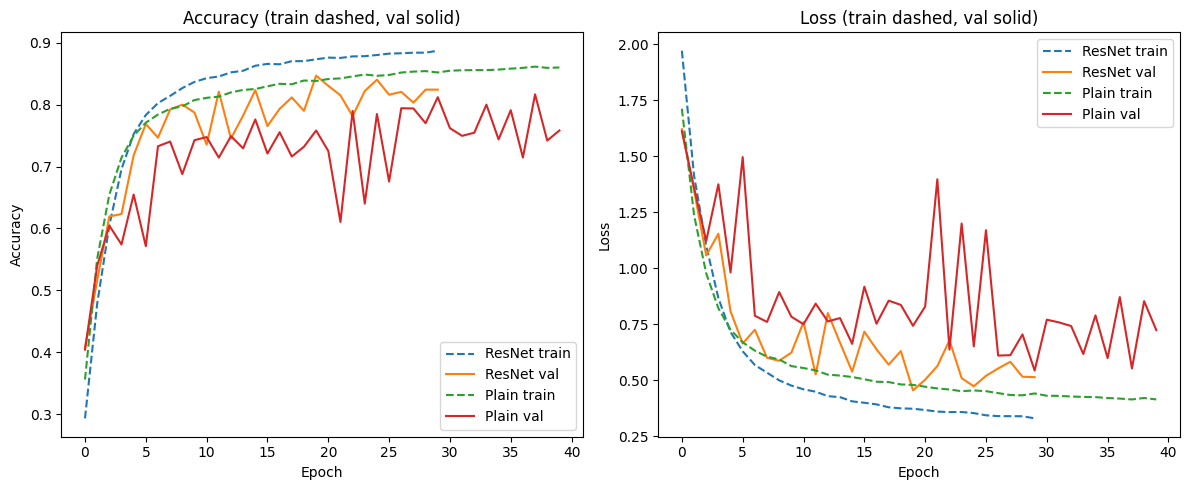

In [ ]:
def run_training(model, train_loader, val_loader, config, model_name, patience=10, min_delta=0.001):
    model.to(device)  # Move model to the specified device
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=config['lr'], momentum=config['momentum'], weight_decay=config['weight_decay'])

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val_acc = 0.0
    best_val_loss = float('inf')
    best_model_wts = copy.deepcopy(model.state_dict())
    epochs_no_improve = 0

    for epoch in range(config['epochs']):
        print(f'Epoch {epoch+1}/{config["epochs"]}')
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate(model, val_loader, criterion, device)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

        # Save best model based on validation accuracy
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), os.path.join(config['save_dir'], f'{model_name}_best.pth'))

        # Early stopping logic
        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print(f'Early stopping after {patience} epochs with no improvement in validation loss.')
                break


    model.load_state_dict(best_model_wts) # Load best model weights
    return history

quick_cfg = CONFIG.copy()
quick_cfg.update({'epochs': 100})
print('=== Quick test: ResNet20 ===')
h_res = run_training(resnet20(), train_loader, val_loader, quick_cfg, model_name='resnet20_quick')
print('=== Quick test: PlainNet20 ===')
h_plain = run_training(plain20(), train_loader, val_loader, quick_cfg, model_name='plain20_quick')


plot_history([h_res, h_plain], ['ResNet', 'Plain'])

Epoch 1/25


Train Loss: 1.8636, Train Acc: 0.3168
Val Loss: 1.6203, Val Acc: 0.4072
Epoch 2/25


Train Loss: 1.2537, Train Acc: 0.5462
Val Loss: 1.1754, Val Acc: 0.5758
Epoch 3/25


Train Loss: 0.9442, Train Acc: 0.6655
Val Loss: 1.1015, Val Acc: 0.5950
Epoch 4/25


Train Loss: 0.7563, Train Acc: 0.7359
Val Loss: 0.8570, Val Acc: 0.7134
Epoch 5/25


Train Loss: 0.6455, Train Acc: 0.7763
Val Loss: 0.9045, Val Acc: 0.7096
Epoch 6/25


Train Loss: 0.5826, Train Acc: 0.8001
Val Loss: 1.0067, Val Acc: 0.6768
Epoch 7/25


Train Loss: 0.5380, Train Acc: 0.8159
Val Loss: 0.7557, Val Acc: 0.7512
Epoch 8/25


Train Loss: 0.5074, Train Acc: 0.8262
Val Loss: 1.0058, Val Acc: 0.6862
Epoch 9/25


Train Loss: 0.4895, Train Acc: 0.8314
Val Loss: 0.7047, Val Acc: 0.7576
Epoch 10/25


Train Loss: 0.4692, Train Acc: 0.8384
Val Loss: 0.6018, Val Acc: 0.7930
Epoch 11/25


Train Loss: 0.4474, Train Acc: 0.8458
Val Loss: 0.6449, Val Acc: 0.7810
Epoch 12/25


Train Loss: 0.4341, Train Acc: 0.8512
Val Loss: 0.6456, Val Acc: 0.7892
Epoch 13/25


Train Loss: 0.4236, Train Acc: 0.8546
Val Loss: 0.6044, Val Acc: 0.7944
Epoch 14/25


Train Loss: 0.4096, Train Acc: 0.8595
Val Loss: 0.6742, Val Acc: 0.7742
Epoch 15/25


Train Loss: 0.4025, Train Acc: 0.8615
Val Loss: 0.5937, Val Acc: 0.7954
Epoch 16/25


Train Loss: 0.3952, Train Acc: 0.8643
Val Loss: 0.6432, Val Acc: 0.7918
Epoch 17/25


Train Loss: 0.3839, Train Acc: 0.8693
Val Loss: 0.6920, Val Acc: 0.7706
Epoch 18/25


Train Loss: 0.3827, Train Acc: 0.8701
Val Loss: 0.5549, Val Acc: 0.8104
Epoch 19/25


Train Loss: 0.3724, Train Acc: 0.8727
Val Loss: 0.5866, Val Acc: 0.8052
Epoch 20/25


Train Loss: 0.3700, Train Acc: 0.8729
Val Loss: 0.7527, Val Acc: 0.7560
Epoch 21/25


Train Loss: 0.3666, Train Acc: 0.8739
Val Loss: 0.7023, Val Acc: 0.7670
Epoch 22/25


Train Loss: 0.3564, Train Acc: 0.8774
Val Loss: 0.5230, Val Acc: 0.8192
Epoch 23/25


Train Loss: 0.3473, Train Acc: 0.8799
Val Loss: 0.6799, Val Acc: 0.7776
Epoch 24/25


Train Loss: 0.3538, Train Acc: 0.8781
Val Loss: 0.4871, Val Acc: 0.8380
Epoch 25/25


Train Loss: 0.3439, Train Acc: 0.8823
Val Loss: 0.4644, Val Acc: 0.8380
Epoch 1/25


Train Loss: 1.7562, Train Acc: 0.3393
Val Loss: 1.6226, Val Acc: 0.3948
Epoch 2/25


Train Loss: 1.3449, Train Acc: 0.5111
Val Loss: 1.4467, Val Acc: 0.4932
Epoch 3/25


Train Loss: 1.0399, Train Acc: 0.6324
Val Loss: 0.9967, Val Acc: 0.6516
Epoch 4/25


Train Loss: 0.8578, Train Acc: 0.7018
Val Loss: 0.9857, Val Acc: 0.6584
Epoch 5/25


Train Loss: 0.7500, Train Acc: 0.7399
Val Loss: 0.8564, Val Acc: 0.7000
Epoch 6/25


Train Loss: 0.6839, Train Acc: 0.7652
Val Loss: 0.7448, Val Acc: 0.7434
Epoch 7/25


Train Loss: 0.6400, Train Acc: 0.7823
Val Loss: 0.7310, Val Acc: 0.7584
Epoch 8/25


Train Loss: 0.6134, Train Acc: 0.7904
Val Loss: 0.9555, Val Acc: 0.6758
Epoch 9/25


Train Loss: 0.5918, Train Acc: 0.7980
Val Loss: 1.0443, Val Acc: 0.6700
Epoch 10/25


Train Loss: 0.5805, Train Acc: 0.8021
Val Loss: 1.1362, Val Acc: 0.6442
Epoch 11/25


Train Loss: 0.5573, Train Acc: 0.8094
Val Loss: 0.7159, Val Acc: 0.7566
Epoch 12/25


Train Loss: 0.5415, Train Acc: 0.8178
Val Loss: 0.8783, Val Acc: 0.6930
Epoch 13/25


Train Loss: 0.5271, Train Acc: 0.8204
Val Loss: 0.8299, Val Acc: 0.7340
Epoch 14/25


Train Loss: 0.5292, Train Acc: 0.8205
Val Loss: 0.6999, Val Acc: 0.7698
Epoch 15/25


Train Loss: 0.5122, Train Acc: 0.8277
Val Loss: 0.8997, Val Acc: 0.7166
Epoch 16/25


Train Loss: 0.5074, Train Acc: 0.8275
Val Loss: 0.7753, Val Acc: 0.7472
Epoch 17/25


Train Loss: 0.4966, Train Acc: 0.8322
Val Loss: 0.7104, Val Acc: 0.7584
Epoch 18/25


Train Loss: 0.4871, Train Acc: 0.8353
Val Loss: 0.7754, Val Acc: 0.7420
Epoch 19/25


Train Loss: 0.4819, Train Acc: 0.8359
Val Loss: 0.7801, Val Acc: 0.7426
Epoch 20/25


Train Loss: 0.4762, Train Acc: 0.8390
Val Loss: 0.8156, Val Acc: 0.7408
Epoch 21/25


Train Loss: 0.4712, Train Acc: 0.8421
Val Loss: 0.7576, Val Acc: 0.7546
Epoch 22/25


Train Loss: 0.4725, Train Acc: 0.8389
Val Loss: 0.7875, Val Acc: 0.7474
Epoch 23/25


Train Loss: 0.4679, Train Acc: 0.8408
Val Loss: 0.7044, Val Acc: 0.7676
Epoch 24/25


Train Loss: 0.4616, Train Acc: 0.8431
Val Loss: 0.8523, Val Acc: 0.7212
Early stopping after 10 epochs with no improvement in validation loss.


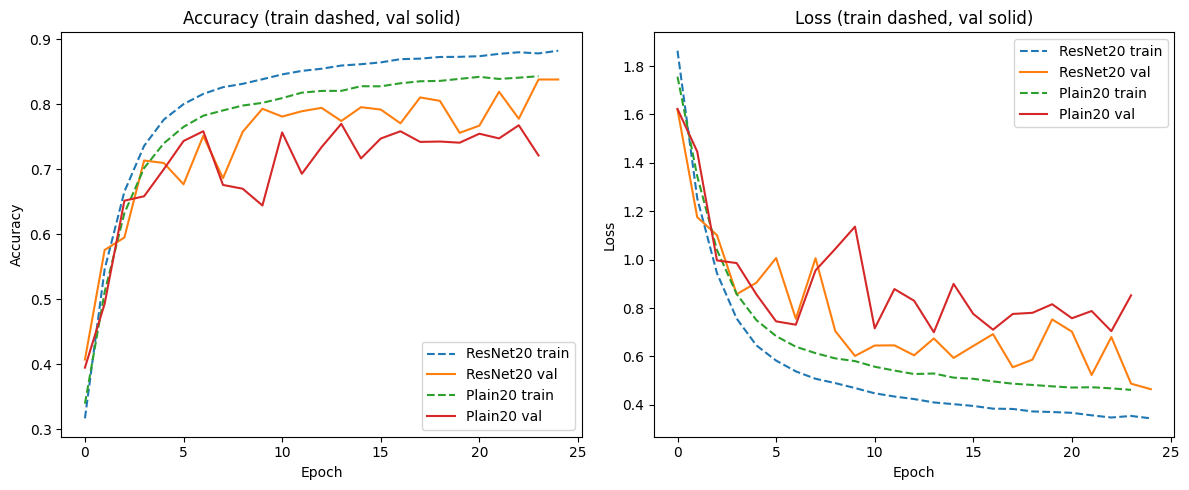

In [ ]:
CONFIG['epochs'] = 25
hist_res = run_training(resnet20(), train_loader, val_loader, CONFIG, model_name='resnet20')
hist_plain = run_training(plain20(), train_loader, val_loader, CONFIG, model_name='plain20')
plot_history([hist_res, hist_plain], ['ResNet20', 'Plain20'], out_path='training_comparison.png')


Test acc: 0.8281


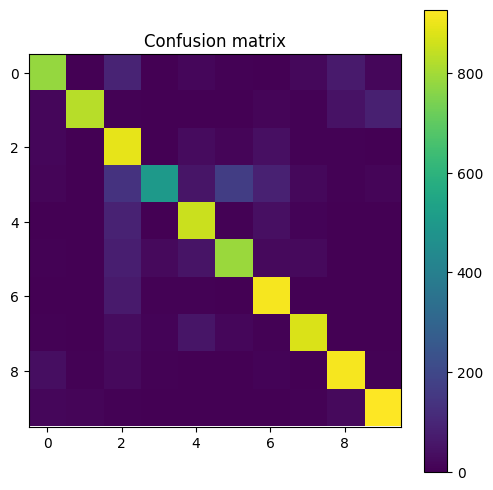

In [ ]:
ckpt = torch.load(os.path.join(CONFIG['save_dir'], 'resnet20_best.pth'), map_location=device)
model = resnet20()
model.load_state_dict(ckpt)
model = model.to(device)
test_acc, cm = evaluate_test_and_confusion(model, test_loader, device)
print('Test acc:', test_acc)
plt.figure(figsize=(6,6)); plt.imshow(cm); plt.title('Confusion matrix'); plt.colorbar(); plt.show()

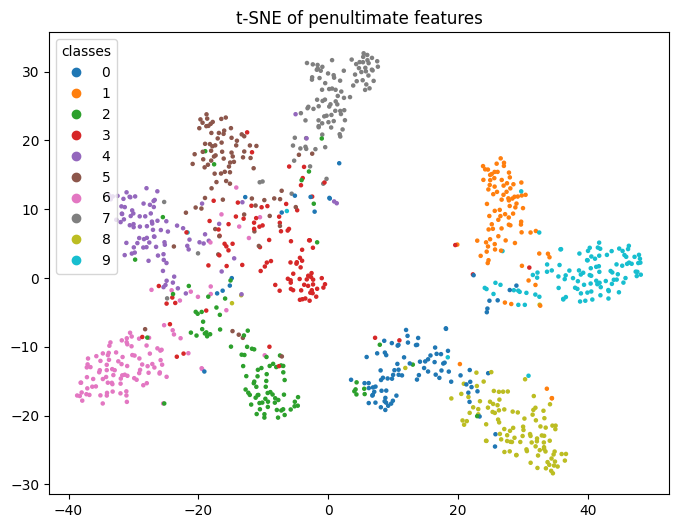

In [ ]:
feats, labs = extract_features(model, test_loader, device, max_samples=1000)
tsne = TSNE(n_components=2, random_state=CONFIG['seed'])
proj = tsne.fit_transform(feats)
plt.figure(figsize=(8,6))
scatter = plt.scatter(proj[:,0], proj[:,1], c=labs, cmap='tab10', s=5)
plt.legend(*scatter.legend_elements(), title='classes')
plt.title('t-SNE of penultimate features')
plt.show()



--- Training with 10% of CIFAR-10 ---
Epoch 1/25


Train Loss: 2.6690, Train Acc: 0.1742
Val Loss: 4.2998, Val Acc: 0.1566
Epoch 2/25


Train Loss: 2.1057, Train Acc: 0.2074
Val Loss: 2.1458, Val Acc: 0.2102
Epoch 3/25


Train Loss: 1.9999, Train Acc: 0.2256
Val Loss: 1.9883, Val Acc: 0.2080
Epoch 4/25


Train Loss: 1.9260, Train Acc: 0.2560
Val Loss: 1.9241, Val Acc: 0.2460
Epoch 5/25


Train Loss: 1.8211, Train Acc: 0.2926
Val Loss: 2.1503, Val Acc: 0.2264
Epoch 6/25


Train Loss: 1.8732, Train Acc: 0.2792
Val Loss: 1.9815, Val Acc: 0.2682
Epoch 7/25


Train Loss: 1.8998, Train Acc: 0.2614
Val Loss: 1.8454, Val Acc: 0.2830
Epoch 8/25


Train Loss: 1.8178, Train Acc: 0.2940
Val Loss: 1.7523, Val Acc: 0.3282
Epoch 9/25


Train Loss: 1.7206, Train Acc: 0.3396
Val Loss: 1.8899, Val Acc: 0.2908
Epoch 10/25


Train Loss: 1.7255, Train Acc: 0.3372
Val Loss: 1.7379, Val Acc: 0.3396
Epoch 11/25


Train Loss: 1.6746, Train Acc: 0.3642
Val Loss: 1.6669, Val Acc: 0.3772
Epoch 12/25


Train Loss: 1.6886, Train Acc: 0.3824
Val Loss: 1.7057, Val Acc: 0.3618
Epoch 13/25


Train Loss: 1.6149, Train Acc: 0.3956
Val Loss: 1.6011, Val Acc: 0.3976
Epoch 14/25


Train Loss: 1.5522, Train Acc: 0.4138
Val Loss: 1.6952, Val Acc: 0.3658
Epoch 15/25


Train Loss: 1.5603, Train Acc: 0.4102
Val Loss: 1.5647, Val Acc: 0.4194
Epoch 16/25


Train Loss: 1.5240, Train Acc: 0.4332
Val Loss: 1.5883, Val Acc: 0.4172
Epoch 17/25


Train Loss: 1.4490, Train Acc: 0.4712
Val Loss: 1.5208, Val Acc: 0.4480
Epoch 18/25


Train Loss: 1.4717, Train Acc: 0.4594
Val Loss: 1.6455, Val Acc: 0.3984
Epoch 19/25


Train Loss: 1.5332, Train Acc: 0.4294
Val Loss: 1.5482, Val Acc: 0.4266
Epoch 20/25


Train Loss: 1.4704, Train Acc: 0.4642
Val Loss: 1.5858, Val Acc: 0.4192
Epoch 21/25


Train Loss: 1.4665, Train Acc: 0.4574
Val Loss: 1.7778, Val Acc: 0.4064
Epoch 22/25


Train Loss: 1.3688, Train Acc: 0.4992
Val Loss: 1.4494, Val Acc: 0.4798
Epoch 23/25


Train Loss: 1.2928, Train Acc: 0.5214
Val Loss: 1.4491, Val Acc: 0.4740
Epoch 24/25


Train Loss: 1.4112, Train Acc: 0.4846
Val Loss: 1.3479, Val Acc: 0.5170
Epoch 25/25


Train Loss: 1.2917, Train Acc: 0.5284
Val Loss: 1.5653, Val Acc: 0.4586


Epoch 1/25


Train Loss: 2.1397, Train Acc: 0.1930
Val Loss: 6.9894, Val Acc: 0.1910
Epoch 2/25


Train Loss: 1.9695, Train Acc: 0.2430
Val Loss: 1.9343, Val Acc: 0.2712
Epoch 3/25


Train Loss: 1.8527, Train Acc: 0.2946
Val Loss: 1.8533, Val Acc: 0.2890
Epoch 4/25


Train Loss: 1.7924, Train Acc: 0.3172
Val Loss: 1.8013, Val Acc: 0.3148
Epoch 5/25


Train Loss: 1.7686, Train Acc: 0.3192
Val Loss: 1.7905, Val Acc: 0.3190
Epoch 6/25


Train Loss: 1.7435, Train Acc: 0.3470
Val Loss: 1.8995, Val Acc: 0.3008
Epoch 7/25


Train Loss: 1.6755, Train Acc: 0.3808
Val Loss: 1.7106, Val Acc: 0.3680
Epoch 8/25


Train Loss: 1.6236, Train Acc: 0.3972
Val Loss: 1.8312, Val Acc: 0.3388
Epoch 9/25


Train Loss: 1.6074, Train Acc: 0.3992
Val Loss: 1.6015, Val Acc: 0.4276
Epoch 10/25


Train Loss: 1.5379, Train Acc: 0.4358
Val Loss: 1.8007, Val Acc: 0.3368
Epoch 11/25


Train Loss: 1.5196, Train Acc: 0.4464
Val Loss: 1.8018, Val Acc: 0.3610
Epoch 12/25


Train Loss: 1.4527, Train Acc: 0.4726
Val Loss: 1.7446, Val Acc: 0.4164
Epoch 13/25


Train Loss: 1.4716, Train Acc: 0.4726
Val Loss: 1.8657, Val Acc: 0.4002
Epoch 14/25


Train Loss: 1.4170, Train Acc: 0.4782
Val Loss: 1.5964, Val Acc: 0.4352
Epoch 15/25


Train Loss: 1.3298, Train Acc: 0.5074
Val Loss: 1.5698, Val Acc: 0.4450
Epoch 16/25


Train Loss: 1.3369, Train Acc: 0.5096
Val Loss: 1.4691, Val Acc: 0.4796
Epoch 17/25


Train Loss: 1.2536, Train Acc: 0.5458
Val Loss: 1.5041, Val Acc: 0.4590
Epoch 18/25


Train Loss: 1.2857, Train Acc: 0.5244
Val Loss: 1.4587, Val Acc: 0.4834
Epoch 19/25


Train Loss: 1.1898, Train Acc: 0.5768
Val Loss: 1.4601, Val Acc: 0.4764
Epoch 20/25


Train Loss: 1.1504, Train Acc: 0.5866
Val Loss: 1.5065, Val Acc: 0.5020
Epoch 21/25


Train Loss: 1.1894, Train Acc: 0.5720
Val Loss: 1.4488, Val Acc: 0.4916
Epoch 22/25


Train Loss: 1.1508, Train Acc: 0.5918
Val Loss: 1.6346, Val Acc: 0.4638
Epoch 23/25


Train Loss: 1.1080, Train Acc: 0.6018
Val Loss: 1.3030, Val Acc: 0.5336
Epoch 24/25


Train Loss: 1.1023, Train Acc: 0.6044
Val Loss: 1.2878, Val Acc: 0.5338
Epoch 25/25


Train Loss: 1.0410, Train Acc: 0.6346
Val Loss: 1.5412, Val Acc: 0.4856



--- Training with 25% of CIFAR-10 ---
Epoch 1/25


Train Loss: 2.1104, Train Acc: 0.2467
Val Loss: 1.8568, Val Acc: 0.2906
Epoch 2/25


Train Loss: 1.6998, Train Acc: 0.3526
Val Loss: 1.7237, Val Acc: 0.3606
Epoch 3/25


Train Loss: 1.5418, Train Acc: 0.4198
Val Loss: 1.5451, Val Acc: 0.4342
Epoch 4/25


Train Loss: 1.4225, Train Acc: 0.4742
Val Loss: 1.3895, Val Acc: 0.5034
Epoch 5/25


Train Loss: 1.3136, Train Acc: 0.5135
Val Loss: 1.5471, Val Acc: 0.4454
Epoch 6/25


Train Loss: 1.2226, Train Acc: 0.5558
Val Loss: 1.5315, Val Acc: 0.4688
Epoch 7/25


Train Loss: 1.1028, Train Acc: 0.6030
Val Loss: 1.3397, Val Acc: 0.5234
Epoch 8/25


Train Loss: 1.0358, Train Acc: 0.6309
Val Loss: 1.1810, Val Acc: 0.5924
Epoch 9/25


Train Loss: 0.9716, Train Acc: 0.6508
Val Loss: 1.2281, Val Acc: 0.5564
Epoch 10/25


Train Loss: 0.9085, Train Acc: 0.6755
Val Loss: 1.0088, Val Acc: 0.6458
Epoch 11/25


Train Loss: 0.8587, Train Acc: 0.6962
Val Loss: 1.5309, Val Acc: 0.5306
Epoch 12/25


Train Loss: 0.8115, Train Acc: 0.7120
Val Loss: 1.1918, Val Acc: 0.5914
Epoch 13/25


Train Loss: 0.7726, Train Acc: 0.7257
Val Loss: 0.8247, Val Acc: 0.7108
Epoch 14/25


Train Loss: 0.7108, Train Acc: 0.7506
Val Loss: 1.0564, Val Acc: 0.6474
Epoch 15/25


Train Loss: 0.6796, Train Acc: 0.7594
Val Loss: 0.8164, Val Acc: 0.7302
Epoch 16/25


Train Loss: 0.6452, Train Acc: 0.7747
Val Loss: 0.9833, Val Acc: 0.6710
Epoch 17/25


Train Loss: 0.5973, Train Acc: 0.7882
Val Loss: 1.0305, Val Acc: 0.6762
Epoch 18/25


Train Loss: 0.5939, Train Acc: 0.7978
Val Loss: 0.7740, Val Acc: 0.7358
Epoch 19/25


Train Loss: 0.5502, Train Acc: 0.8127
Val Loss: 0.8267, Val Acc: 0.7192
Epoch 20/25


Train Loss: 0.5161, Train Acc: 0.8220
Val Loss: 0.9083, Val Acc: 0.7066
Epoch 21/25


Train Loss: 0.5173, Train Acc: 0.8178
Val Loss: 0.7130, Val Acc: 0.7568
Epoch 22/25


Train Loss: 0.4914, Train Acc: 0.8310
Val Loss: 0.7320, Val Acc: 0.7540
Epoch 23/25


Train Loss: 0.4835, Train Acc: 0.8334
Val Loss: 0.7574, Val Acc: 0.7448
Epoch 24/25


Train Loss: 0.4607, Train Acc: 0.8430
Val Loss: 0.7268, Val Acc: 0.7580
Epoch 25/25


Train Loss: 0.4459, Train Acc: 0.8454
Val Loss: 0.7876, Val Acc: 0.7452


Epoch 1/25


Train Loss: 1.9787, Train Acc: 0.2569
Val Loss: 1.9046, Val Acc: 0.2788
Epoch 2/25


Train Loss: 1.7413, Train Acc: 0.3404
Val Loss: 1.8141, Val Acc: 0.3266
Epoch 3/25


Train Loss: 1.6614, Train Acc: 0.3786
Val Loss: 1.7256, Val Acc: 0.3632
Epoch 4/25


Train Loss: 1.5375, Train Acc: 0.4272
Val Loss: 1.7485, Val Acc: 0.3428
Epoch 5/25


Train Loss: 1.4388, Train Acc: 0.4646
Val Loss: 1.6020, Val Acc: 0.4278
Epoch 6/25


Train Loss: 1.3236, Train Acc: 0.5161
Val Loss: 1.3585, Val Acc: 0.5004
Epoch 7/25


Train Loss: 1.1873, Train Acc: 0.5645
Val Loss: 1.5773, Val Acc: 0.4688
Epoch 8/25


Train Loss: 1.0848, Train Acc: 0.6112
Val Loss: 1.3356, Val Acc: 0.5266
Epoch 9/25


Train Loss: 1.0100, Train Acc: 0.6410
Val Loss: 1.2980, Val Acc: 0.5584
Epoch 10/25


Train Loss: 0.9414, Train Acc: 0.6708
Val Loss: 1.0412, Val Acc: 0.6296
Epoch 11/25


Train Loss: 0.8811, Train Acc: 0.6903
Val Loss: 1.2852, Val Acc: 0.5780
Epoch 12/25


Train Loss: 0.8322, Train Acc: 0.7082
Val Loss: 1.0023, Val Acc: 0.6572
Epoch 13/25


Train Loss: 0.7971, Train Acc: 0.7233
Val Loss: 0.9363, Val Acc: 0.6760
Epoch 14/25


Train Loss: 0.7537, Train Acc: 0.7351
Val Loss: 0.9105, Val Acc: 0.6784
Epoch 15/25


Train Loss: 0.7150, Train Acc: 0.7505
Val Loss: 0.9983, Val Acc: 0.6692
Epoch 16/25


Train Loss: 0.6834, Train Acc: 0.7661
Val Loss: 0.8807, Val Acc: 0.7076
Epoch 17/25


Train Loss: 0.6717, Train Acc: 0.7685
Val Loss: 0.8446, Val Acc: 0.7014
Epoch 18/25


Train Loss: 0.6384, Train Acc: 0.7818
Val Loss: 0.7942, Val Acc: 0.7264
Epoch 19/25


Train Loss: 0.6212, Train Acc: 0.7821
Val Loss: 0.8873, Val Acc: 0.6956
Epoch 20/25


Train Loss: 0.5998, Train Acc: 0.7957
Val Loss: 0.8259, Val Acc: 0.7182
Epoch 21/25


Train Loss: 0.5749, Train Acc: 0.7982
Val Loss: 0.8857, Val Acc: 0.6914
Epoch 22/25


Train Loss: 0.5579, Train Acc: 0.8076
Val Loss: 0.8983, Val Acc: 0.6894
Epoch 23/25


Train Loss: 0.5462, Train Acc: 0.8141
Val Loss: 0.9608, Val Acc: 0.6824
Epoch 24/25


Train Loss: 0.5440, Train Acc: 0.8154
Val Loss: 1.1645, Val Acc: 0.6418
Epoch 25/25


Train Loss: 0.5356, Train Acc: 0.8142
Val Loss: 0.7614, Val Acc: 0.7480



--- Training with 50% of CIFAR-10 ---
Epoch 1/25


Train Loss: 2.0194, Train Acc: 0.2675
Val Loss: 1.7624, Val Acc: 0.3418
Epoch 2/25


Train Loss: 1.5971, Train Acc: 0.4041
Val Loss: 1.6125, Val Acc: 0.4120
Epoch 3/25


Train Loss: 1.3879, Train Acc: 0.4912
Val Loss: 1.4356, Val Acc: 0.4908
Epoch 4/25


Train Loss: 1.2379, Train Acc: 0.5518
Val Loss: 1.2436, Val Acc: 0.5608
Epoch 5/25


Train Loss: 1.0620, Train Acc: 0.6190
Val Loss: 1.1360, Val Acc: 0.5944
Epoch 6/25


Train Loss: 0.9388, Train Acc: 0.6659
Val Loss: 0.9979, Val Acc: 0.6498
Epoch 7/25


Train Loss: 0.8560, Train Acc: 0.6958
Val Loss: 1.0702, Val Acc: 0.6308
Epoch 8/25


Train Loss: 0.7587, Train Acc: 0.7366
Val Loss: 0.8479, Val Acc: 0.7036
Epoch 9/25


Train Loss: 0.6815, Train Acc: 0.7641
Val Loss: 0.8641, Val Acc: 0.7002
Epoch 10/25


Train Loss: 0.6317, Train Acc: 0.7794
Val Loss: 0.8049, Val Acc: 0.7196
Epoch 11/25


Train Loss: 0.5863, Train Acc: 0.7972
Val Loss: 0.8477, Val Acc: 0.7120
Epoch 12/25


Train Loss: 0.5548, Train Acc: 0.8084
Val Loss: 0.6153, Val Acc: 0.7908
Epoch 13/25


Train Loss: 0.5293, Train Acc: 0.8161
Val Loss: 0.7762, Val Acc: 0.7382
Epoch 14/25


Train Loss: 0.4966, Train Acc: 0.8296
Val Loss: 0.7200, Val Acc: 0.7626
Epoch 15/25


Train Loss: 0.4741, Train Acc: 0.8358
Val Loss: 0.5917, Val Acc: 0.7966
Epoch 16/25


Train Loss: 0.4662, Train Acc: 0.8402
Val Loss: 0.6914, Val Acc: 0.7626
Epoch 17/25


Train Loss: 0.4574, Train Acc: 0.8458
Val Loss: 0.5603, Val Acc: 0.8038
Epoch 18/25


Train Loss: 0.4400, Train Acc: 0.8481
Val Loss: 0.7098, Val Acc: 0.7688
Epoch 19/25


Train Loss: 0.4255, Train Acc: 0.8520
Val Loss: 0.7068, Val Acc: 0.7672
Epoch 20/25


Train Loss: 0.4116, Train Acc: 0.8587
Val Loss: 0.8458, Val Acc: 0.7182
Epoch 21/25


Train Loss: 0.4086, Train Acc: 0.8596
Val Loss: 0.5785, Val Acc: 0.8076
Epoch 22/25


Train Loss: 0.3894, Train Acc: 0.8636
Val Loss: 0.5013, Val Acc: 0.8320
Epoch 23/25


Train Loss: 0.3851, Train Acc: 0.8667
Val Loss: 0.5831, Val Acc: 0.7998
Epoch 24/25


Train Loss: 0.3823, Train Acc: 0.8678
Val Loss: 0.5617, Val Acc: 0.8032
Epoch 25/25


Train Loss: 0.3737, Train Acc: 0.8714
Val Loss: 0.6811, Val Acc: 0.7742


Epoch 1/25


Train Loss: 1.8775, Train Acc: 0.2936
Val Loss: 1.7949, Val Acc: 0.3348
Epoch 2/25


Train Loss: 1.5700, Train Acc: 0.4149
Val Loss: 1.7597, Val Acc: 0.4024
Epoch 3/25


Train Loss: 1.3524, Train Acc: 0.5042
Val Loss: 1.3903, Val Acc: 0.4926
Epoch 4/25


Train Loss: 1.1600, Train Acc: 0.5802
Val Loss: 1.1112, Val Acc: 0.5994
Epoch 5/25


Train Loss: 1.0415, Train Acc: 0.6264
Val Loss: 1.2840, Val Acc: 0.5596
Epoch 6/25


Train Loss: 0.9369, Train Acc: 0.6664
Val Loss: 0.9746, Val Acc: 0.6514
Epoch 7/25


Train Loss: 0.8546, Train Acc: 0.6999
Val Loss: 1.1137, Val Acc: 0.6192
Epoch 8/25


Train Loss: 0.8060, Train Acc: 0.7197
Val Loss: 1.2279, Val Acc: 0.5668
Epoch 9/25


Train Loss: 0.7433, Train Acc: 0.7442
Val Loss: 1.0291, Val Acc: 0.6440
Epoch 10/25


Train Loss: 0.7078, Train Acc: 0.7588
Val Loss: 0.9899, Val Acc: 0.6764
Epoch 11/25


Train Loss: 0.6824, Train Acc: 0.7664
Val Loss: 0.9726, Val Acc: 0.6758
Epoch 12/25


Train Loss: 0.6435, Train Acc: 0.7778
Val Loss: 0.7223, Val Acc: 0.7464
Epoch 13/25


Train Loss: 0.6298, Train Acc: 0.7818
Val Loss: 0.8850, Val Acc: 0.6974
Epoch 14/25


Train Loss: 0.5897, Train Acc: 0.7959
Val Loss: 0.9371, Val Acc: 0.6848
Epoch 15/25


Train Loss: 0.5985, Train Acc: 0.7962
Val Loss: 1.6757, Val Acc: 0.5322
Epoch 16/25


Train Loss: 0.5785, Train Acc: 0.8025
Val Loss: 0.9149, Val Acc: 0.7070
Epoch 17/25


Train Loss: 0.5706, Train Acc: 0.8046
Val Loss: 0.6980, Val Acc: 0.7542
Epoch 18/25


Train Loss: 0.5451, Train Acc: 0.8160
Val Loss: 0.8883, Val Acc: 0.6960
Epoch 19/25


Train Loss: 0.5444, Train Acc: 0.8148
Val Loss: 0.8066, Val Acc: 0.7244
Epoch 20/25


Train Loss: 0.5314, Train Acc: 0.8184
Val Loss: 0.7439, Val Acc: 0.7558
Epoch 21/25


Train Loss: 0.5285, Train Acc: 0.8182
Val Loss: 0.8354, Val Acc: 0.7250
Epoch 22/25


Train Loss: 0.5023, Train Acc: 0.8274
Val Loss: 1.1973, Val Acc: 0.6452
Epoch 23/25


Train Loss: 0.4993, Train Acc: 0.8301
Val Loss: 1.0290, Val Acc: 0.6630
Epoch 24/25


Train Loss: 0.5089, Train Acc: 0.8271
Val Loss: 0.9131, Val Acc: 0.6952
Epoch 25/25


Train Loss: 0.4889, Train Acc: 0.8316
Val Loss: 0.7010, Val Acc: 0.7638



--- Training with 100% of CIFAR-10 ---
Epoch 1/25


Train Loss: 1.9678, Train Acc: 0.2980
Val Loss: 1.6519, Val Acc: 0.3916
Epoch 2/25


Train Loss: 1.3713, Train Acc: 0.4982
Val Loss: 1.2750, Val Acc: 0.5536
Epoch 3/25


Train Loss: 1.0216, Train Acc: 0.6358
Val Loss: 0.8966, Val Acc: 0.6778
Epoch 4/25


Train Loss: 0.7865, Train Acc: 0.7267
Val Loss: 0.9245, Val Acc: 0.6954
Epoch 5/25


Train Loss: 0.6592, Train Acc: 0.7711
Val Loss: 0.6720, Val Acc: 0.7624
Epoch 6/25


Train Loss: 0.5774, Train Acc: 0.8020
Val Loss: 0.6522, Val Acc: 0.7736
Epoch 7/25


Train Loss: 0.5334, Train Acc: 0.8180
Val Loss: 0.5786, Val Acc: 0.8048
Epoch 8/25


Train Loss: 0.5038, Train Acc: 0.8279
Val Loss: 0.5270, Val Acc: 0.8146
Epoch 9/25


Train Loss: 0.4822, Train Acc: 0.8342
Val Loss: 0.6185, Val Acc: 0.7868
Epoch 10/25


Train Loss: 0.4558, Train Acc: 0.8437
Val Loss: 0.6301, Val Acc: 0.7802
Epoch 11/25


Train Loss: 0.4520, Train Acc: 0.8447
Val Loss: 0.4835, Val Acc: 0.8324
Epoch 12/25


Train Loss: 0.4319, Train Acc: 0.8506
Val Loss: 0.5903, Val Acc: 0.7928
Epoch 13/25


Train Loss: 0.4196, Train Acc: 0.8559
Val Loss: 0.7010, Val Acc: 0.7700
Epoch 14/25


Train Loss: 0.4069, Train Acc: 0.8605
Val Loss: 0.4349, Val Acc: 0.8494
Epoch 15/25


Train Loss: 0.3982, Train Acc: 0.8655
Val Loss: 0.4003, Val Acc: 0.8522
Epoch 16/25


Train Loss: 0.3818, Train Acc: 0.8704
Val Loss: 0.5899, Val Acc: 0.7958
Epoch 17/25


Train Loss: 0.3810, Train Acc: 0.8685
Val Loss: 0.5305, Val Acc: 0.8224
Epoch 18/25


Train Loss: 0.3739, Train Acc: 0.8709
Val Loss: 0.5924, Val Acc: 0.8052
Epoch 19/25


Train Loss: 0.3661, Train Acc: 0.8745
Val Loss: 0.4736, Val Acc: 0.8352
Epoch 20/25


Train Loss: 0.3607, Train Acc: 0.8766
Val Loss: 0.4754, Val Acc: 0.8374
Epoch 21/25


Train Loss: 0.3594, Train Acc: 0.8772
Val Loss: 0.3770, Val Acc: 0.8676
Epoch 22/25


Train Loss: 0.3497, Train Acc: 0.8809
Val Loss: 0.6357, Val Acc: 0.7950
Epoch 23/25


Train Loss: 0.3519, Train Acc: 0.8796
Val Loss: 0.4528, Val Acc: 0.8468
Epoch 24/25


Train Loss: 0.3452, Train Acc: 0.8823
Val Loss: 0.4192, Val Acc: 0.8530
Epoch 25/25


Train Loss: 0.3381, Train Acc: 0.8841
Val Loss: 0.4973, Val Acc: 0.8342


Epoch 1/25


Train Loss: 1.6910, Train Acc: 0.3659
Val Loss: 1.7290, Val Acc: 0.4144
Epoch 2/25


Train Loss: 1.2648, Train Acc: 0.5398
Val Loss: 1.1878, Val Acc: 0.5758
Epoch 3/25


Train Loss: 1.0189, Train Acc: 0.6369
Val Loss: 0.9913, Val Acc: 0.6532
Epoch 4/25


Train Loss: 0.8614, Train Acc: 0.6990
Val Loss: 0.9363, Val Acc: 0.6800
Epoch 5/25


Train Loss: 0.7571, Train Acc: 0.7379
Val Loss: 1.0385, Val Acc: 0.6332
Epoch 6/25


Train Loss: 0.6926, Train Acc: 0.7630
Val Loss: 1.2882, Val Acc: 0.6102
Epoch 7/25


Train Loss: 0.6500, Train Acc: 0.7768
Val Loss: 1.0162, Val Acc: 0.6844
Epoch 8/25


Train Loss: 0.6210, Train Acc: 0.7885
Val Loss: 1.0197, Val Acc: 0.6638
Epoch 9/25


Train Loss: 0.5949, Train Acc: 0.7962
Val Loss: 0.7889, Val Acc: 0.7340
Epoch 10/25


Train Loss: 0.5747, Train Acc: 0.8040
Val Loss: 0.7391, Val Acc: 0.7486
Epoch 11/25


Train Loss: 0.5582, Train Acc: 0.8100
Val Loss: 0.8396, Val Acc: 0.7184
Epoch 12/25


Train Loss: 0.5420, Train Acc: 0.8159
Val Loss: 0.7268, Val Acc: 0.7646
Epoch 13/25


Train Loss: 0.5353, Train Acc: 0.8187
Val Loss: 0.6542, Val Acc: 0.7776
Epoch 14/25


Train Loss: 0.5247, Train Acc: 0.8223
Val Loss: 0.8035, Val Acc: 0.7486
Epoch 15/25


Train Loss: 0.5148, Train Acc: 0.8257
Val Loss: 0.5794, Val Acc: 0.8080
Epoch 16/25


Train Loss: 0.5028, Train Acc: 0.8300
Val Loss: 0.6743, Val Acc: 0.7710
Epoch 17/25


Train Loss: 0.5014, Train Acc: 0.8289
Val Loss: 0.5964, Val Acc: 0.8048
Epoch 18/25


Train Loss: 0.4863, Train Acc: 0.8347
Val Loss: 1.3056, Val Acc: 0.6386
Epoch 19/25


Train Loss: 0.4800, Train Acc: 0.8381
Val Loss: 0.6950, Val Acc: 0.7644
Epoch 20/25


Train Loss: 0.4787, Train Acc: 0.8375
Val Loss: 0.7060, Val Acc: 0.7532
Epoch 21/25


Train Loss: 0.4714, Train Acc: 0.8404
Val Loss: 0.8954, Val Acc: 0.6994
Epoch 22/25


Train Loss: 0.4576, Train Acc: 0.8454
Val Loss: 0.9129, Val Acc: 0.7072
Epoch 23/25


Train Loss: 0.4612, Train Acc: 0.8424
Val Loss: 0.6453, Val Acc: 0.7898
Epoch 24/25


Train Loss: 0.4562, Train Acc: 0.8446
Val Loss: 0.5610, Val Acc: 0.8034
Epoch 25/25


Train Loss: 0.4488, Train Acc: 0.8480
Val Loss: 0.6157, Val Acc: 0.7998


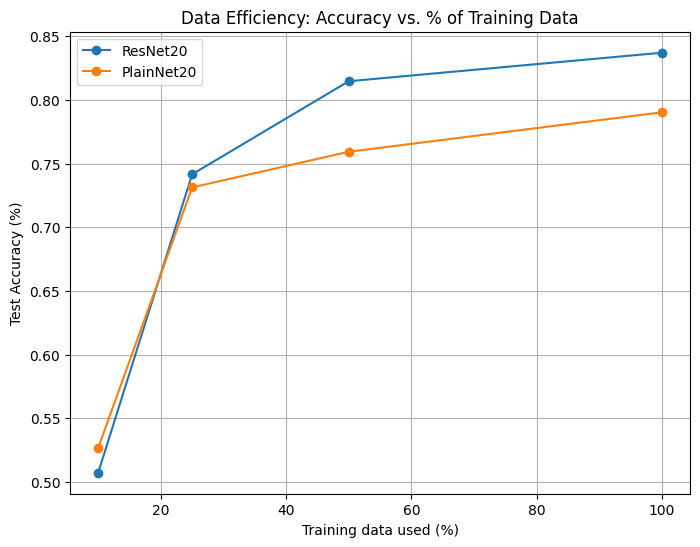

In [ ]:
fractions = [0.1, 0.25, 0.5, 1.0]
results = {}

for frac in fractions:
    print(f"\n--- Training with {int(frac*100)}% of CIFAR-10 ---")

    # Subsample the training dataset
    subset_size = int(len(trainset) * frac)
    subset_indices = torch.randperm(len(trainset))[:subset_size]
    subset = torch.utils.data.Subset(trainset, subset_indices)
    subset_loader = torch.utils.data.DataLoader(
        subset, batch_size=CONFIG['batch_size'], shuffle=True, num_workers=2
    )

    # Train ResNet
    hist_res = run_training(resnet20(), subset_loader, val_loader, CONFIG,
                            model_name=f'resnet20_frac{int(frac*100)}')
    ckpt_res = torch.load(os.path.join(CONFIG['save_dir'], f'resnet20_frac{int(frac*100)}_best.pth'),
                          map_location=device)
    model_res = resnet20().to(device)
    model_res.load_state_dict(ckpt_res)
    acc_res, _ = evaluate_test_and_confusion(model_res, test_loader, device)

    # Train PlainNet
    hist_plain = run_training(plain20(), subset_loader, val_loader, CONFIG,
                              model_name=f'plain20_frac{int(frac*100)}')
    ckpt_plain = torch.load(os.path.join(CONFIG['save_dir'], f'plain20_frac{int(frac*100)}_best.pth'),
                            map_location=device)
    model_plain = plain20().to(device)
    model_plain.load_state_dict(ckpt_plain)
    acc_plain, _ = evaluate_test_and_confusion(model_plain, test_loader, device)

    results[frac] = (acc_res, acc_plain)

# Plot results
fractions_percent = [int(f*100) for f in results.keys()]
res_accs = [v[0] for v in results.values()]
plain_accs = [v[1] for v in results.values()]

plt.figure(figsize=(8,6))
plt.plot(fractions_percent, res_accs, '-o', label='ResNet20')
plt.plot(fractions_percent, plain_accs, '-o', label='PlainNet20')
plt.xlabel("Training data used (%)")
plt.ylabel("Test Accuracy (%)")
plt.title("Data Efficiency: Accuracy vs. % of Training Data")
plt.legend()
plt.grid(True)
plt.show()